In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
os.chdir("../../")
from ReusableCode.bv_vis import biasVarianceCompFrame, plotBV
os.chdir("./DryBeans/notebook/")

import warnings

# Load Data and EDA

In [2]:
df = pd.read_excel('.././data/Dry_Bean_Dataset.xlsx')
df.head()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [3]:
#sns.pairplot(data = df, hue = 'Class', diag_kind=None , markers = '.')

# Analysis

## Split Data

In [4]:
df_original = df

In [5]:
## Manually create dummy variables
df = df_original
class_names = list(df.Class.unique())

def class_ind(x):
    for i, y in enumerate(class_names):
        if y==x:
            return i

df.Class = df.Class.apply(class_ind)


cols = list(df.columns)

## TrainTestSplit
from sklearn.model_selection import train_test_split
random_state = 42
df_train, df_test = train_test_split(df, test_size = .2, shuffle = True, random_state=random_state, stratify=df.Class)
X_train = df_train[cols[:-1]].to_numpy()
X_test = df_test[cols[:-1]].to_numpy()
y_train = df_train[cols[-1]].to_numpy()
y_test = df_test[cols[-1]].to_numpy()

## Grid

from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV

n_repeats = 3
n_folds = 5
cv_trials = n_repeats*n_folds
cv = RepeatedStratifiedKFold(n_repeats = n_repeats, n_splits = n_folds)

## Load All Models

In [6]:
## Multiclass Classification Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB

## Multiclass (no Predict Proba)
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier


## Pre-processing Options
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline




### Model Dictionaries


In [7]:
base_models = {
    'lda':LinearDiscriminantAnalysis(),
    'qda':QuadraticDiscriminantAnalysis(),
    'dt':DecisionTreeClassifier(random_state=random_state),
    'rf':RandomForestClassifier(random_state=random_state),
    'knn':KNeighborsClassifier(),
    'bnb':BernoulliNB(),
    'gnb':GaussianNB()
}

pre_processing = {
    'ss':StandardScaler(),
    #'qt':QuantileTransformer(),
    #'mm':MinMaxScaler(),
    'rs':RobustScaler()
}

### Parameter Grids

In [10]:
maxDepth = 5
maxNeighbors = 5
parameter_grids = {
    'dt':{
        'max_depth':list(range(2,maxDepth+1)),
        'splitter':['best','random']
    },
    'rf':{
        'max_depth':list(range(2,maxDepth+1)),
        'n_estimators':[25, 50, 100]
    },
    'knn':{
        'n_neighbors':list(range(2,maxNeighbors+1)),
        'weights':['uniform','distance']
    }
}

### Metrics

In [31]:
scoring = ['accuracy', 'neg_brier_score','precision_micro','precision_macro','recall_micro','recall_macro', 'f1_micro','f1_macro','neg_log_loss','roc_auc_ovr','roc_auc_ovo']
neat_names = ['Accuracy','Brier Score', 'Precision (Micro)', "Precision (Macro)", 'Recall (Micro)', 'Recall (Macro)', 'F1 (Micro)','F1 (Macro)', 'Log Loss', 'ROC AUC (OVR)','ROC AUC (OVO)']

scoring_dict = {k:v for k,v in zip(neat_names, scoring)}



In [12]:

cv_results = {}
for model_name in base_models.keys():
    model = base_models[model_name]
    if model_name in parameter_grids:
        params = parameter_grids[model_name]
    else:
        params = {}

    
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        return_train_score=True,
        scoring = scoring,
        refit = 'neg_log_loss',
        cv = cv
    )
    grid.fit(X_train,y_train)
    cv_results[model_name] = grid.cv_results_

    for pre in pre_processing.keys():
        pre_pr = pre_processing[pre]
        pipe = Pipeline([
            ('pre',pre_pr), ('model',model)
        ])
        if params:
            pip_params = {'model__'+key:value for key,value in params.items()}
        else:
            pip_params = {}

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=pip_params,
            return_train_score=True,
            scoring = scoring,
            refit = 'neg_log_loss',
            cv = cv
        )
        grid.fit(X_train,y_train)
        cv_results[pre+model_name] = grid.cv_results_



/home/dclancy/miniconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/dclancy/miniconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/dclancy/miniconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/dclancy/miniconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help redu

In [32]:
master_dict = {'model_name':[]}
for model_name,cv_value in cv_results.items():
    grid_df = pd.DataFrame(cv_value)
    model_dict = {}
    for i in range(grid_df.shape[0]):
        row = grid_df.iloc[i]
        entry = {}
        for tt in ["train","test"]:
            for split in range(cv_trials):
                for neat_name, score_name in scoring_dict.items():
                    if score_name[:3] =='neg':
                        sgn = -1
                    else:
                        sgn = 1
                    column_name = 'split'+str(split)+"_"+tt+"_"+score_name
                    if split==0:
                        entry[neat_name+" "+tt[0].upper()+tt[1:]] = [float(sgn*row[column_name])]
                    else:
                        entry[neat_name+" "+tt[0].upper()+tt[1:]].append(float(sgn*row[column_name]))
        model_dict[tuple([model_name] + list(row['params'].items()))] = entry
    for model_key, model_val in model_dict.items():
        master_dict['model_name'].append(model_key)
        for tt in ['train','test']:
            for neat_name in scoring_dict.keys():
                key = neat_name + " "+tt[0].upper() + tt[1:]
                bot = model_val[key]
                if key in master_dict:
                    top = master_dict[key] 
                    master_dict[key] = np.vstack((top,bot))
                else:
                    master_dict[key] = bot
            



In [22]:
master_dict['model_name']

[('lda',),
 ('sslda',),
 ('rslda',),
 ('qda',),
 ('ssqda',),
 ('rsqda',),
 ('dt', ('max_depth', 2), ('splitter', 'best')),
 ('dt', ('max_depth', 2), ('splitter', 'random')),
 ('dt', ('max_depth', 3), ('splitter', 'best')),
 ('dt', ('max_depth', 3), ('splitter', 'random')),
 ('dt', ('max_depth', 4), ('splitter', 'best')),
 ('dt', ('max_depth', 4), ('splitter', 'random')),
 ('dt', ('max_depth', 5), ('splitter', 'best')),
 ('dt', ('max_depth', 5), ('splitter', 'random')),
 ('ssdt', ('model__max_depth', 2), ('model__splitter', 'best')),
 ('ssdt', ('model__max_depth', 2), ('model__splitter', 'random')),
 ('ssdt', ('model__max_depth', 3), ('model__splitter', 'best')),
 ('ssdt', ('model__max_depth', 3), ('model__splitter', 'random')),
 ('ssdt', ('model__max_depth', 4), ('model__splitter', 'best')),
 ('ssdt', ('model__max_depth', 4), ('model__splitter', 'random')),
 ('ssdt', ('model__max_depth', 5), ('model__splitter', 'best')),
 ('ssdt', ('model__max_depth', 5), ('model__splitter', 'random'))

In [34]:
for key, val in master_dict.items():
    if key[-4:]=='Test':
        if key=='Brier Score Test' or key =='Log Loss Test':
            best_val = np.argmin(np.mean(val,axis = 1))
            score_c = np.min(np.mean(val,axis = 1))
        else:
            best_val = np.argmax(np.mean(val,axis = 1))
            score_c = np.max(np.mean(val,axis = 1))
        print(f"The best mean test score for {key[:-5]} is for\n\t{master_dict['model_name'][best_val]}.")
        print(f"\t The score is {score_c}")

The best mean test score for Accuracy is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'distance')).
	 The score is 0.9200035459900996
The best mean test score for Brier Score is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'distance')).
	 The score is 0.1227439207100148
The best mean test score for Precision (Micro) is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'distance')).
	 The score is 0.9200035459900996
The best mean test score for Precision (Macro) is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'distance')).
	 The score is 0.9362045367029703
The best mean test score for Recall (Micro) is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'distance')).
	 The score is 0.9200035459900996
The best mean test score for Recall (Macro) is for
	('ssknn', ('model__n_neighbors', 5), ('model__weights', 'uniform')).
	 The score is 0.9321886687361002
The best mean test score for F1 (Micro) is for
	('ssknn', ('model__n

KNN appears to be the best with standard scaling preprocessing. Let us run more CV analysis with KNN.

In [ ]:
maxNeighbors = 15
parameter_grids['knn2'] = {
        'model__n_neighbors':list(range(2,maxNeighbors+1)),
        'model__weights':['uniform','distance']
    }
n_repeats = 3
n_folds = 10
cv_trials = n_repeats*n_folds
cv2 = RepeatedStratifiedKFold(n_repeats = n_repeats, n_splits = n_folds)


knn_pipe = Pipeline([('ss',StandardScaler()),('model',KNeighborsClassifier())])
grid_knn = GridSearchCV(estimator = knn_pipe,  
            param_grid=parameter_grids['knn2'],
            return_train_score=True,
            scoring = scoring,
            refit = 'neg_log_loss',
            cv = cv2 
)   
grid_knn.fit(X_train,y_train)




NameError: name 'param_renames' is not defined

Accuracy


TypeError: 'Axes' object is not subscriptable

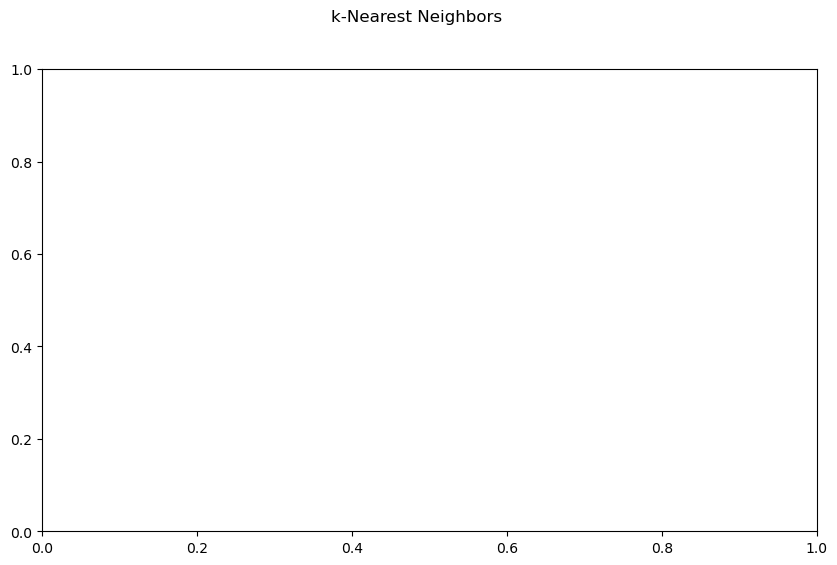

In [ ]:
param_rename = {'Neighbors':'param_model__n_neighbors','Weight':'param_model__weights'}
complexity_param = 'Neighbors'
hues = ['Weight']
title = "k-Nearest Neighbors"


reformatted = biasVarianceCompFrame(
    df = pd.DataFrame(grid_knn.cv_results_),
    metrics = scoring_dict,
    cv_trials = cv_trials,
    parameters = param_rename,
    reverseMetricSign=False
)
style = 'Train/Test'
subplotSize = (10,6)

metric_names = list(scoring_dict.keys())



TypeError: 'Axes' object is not subscriptable

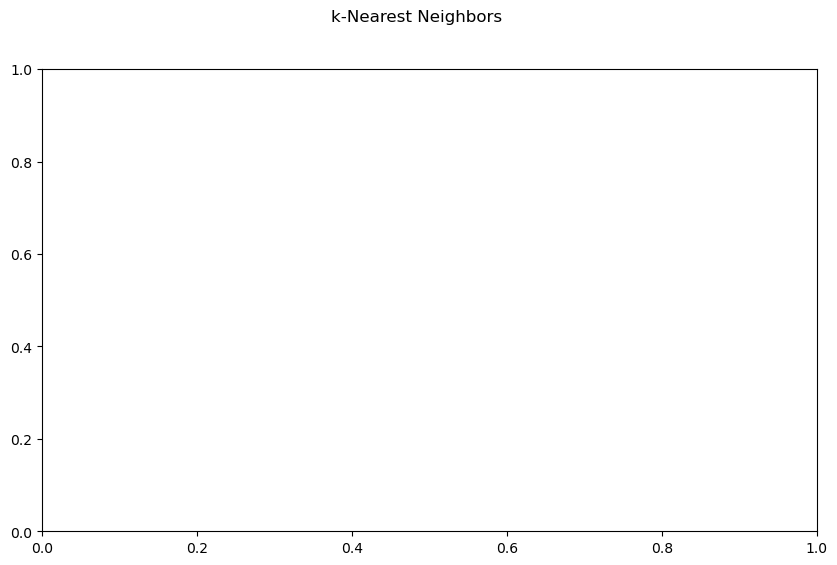